# Imports

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Deep learning with TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

# Deep learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Miscellaneous
import os
import re
import time
import pickle
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

nltk.download('punkt')
nltk.download('stopwords')
torch.manual_seed(42)

Mounted at /content/drive
cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Loading the Data

In [2]:
data = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/cd-data.pt")

# for CREMA-D dataset
cd_data_spect = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/cd-spect.pt")
cd_data_text = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/cd-text.pt")
cd_data_frame = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/cd-frame.pt")

# for Ekman-6 Dataset
ek_data_frame = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ek-frame.pt")
ek_data_spect = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ek-spect.pt")
ek_data_text = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/ek-text.pt", map_location = device)

# cutting the Ekman-6 dataset to Ekman-5
frames = []
spects = []
texts = []
for i in range(250):
  frames.append(ek_data_frame[i])
  spects.append(ek_data_spect[i])
  texts.append(ek_data_text[i])
ek_data_frame = torch.stack(frames)
ek_data_spect = torch.stack(spects)
ek_data_text = torch.stack(texts)

# just doing a sanity check
print(cd_data_spect.size())
print(cd_data_text.size())
print(cd_data_frame.size())
print(ek_data_frame.size())
print(ek_data_spect.size())
print(ek_data_text.size())

VOCAB = 4286

torch.Size([250, 3, 224, 224])
torch.Size([250, 6])
torch.Size([250, 10, 3, 224, 224])
torch.Size([250, 10, 3, 224, 224])
torch.Size([250, 3, 224, 224])
torch.Size([250, 1224])


In [3]:
# Resizing the CREMA-D dataset to having 1224 in each text
cd_texts = []
for i in range(250):
  arr = cd_data_text[i].numpy()
  for j in range(1224 - 6):
    arr = np.concatenate((arr, [0]))
  cd_texts.append(torch.Tensor(arr))

cd_data_text = torch.stack(cd_texts)

# sanity check
print(cd_data_text.size())

torch.Size([250, 1224])


In [14]:
b_size = 10
train_len = (int)(0.9 * len(data))
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_len, len(data) - train_len])
train_loader = DataLoader(train_dataset, batch_size = b_size, shuffle = True, pin_memory = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = b_size, shuffle = True, pin_memory = True, num_workers = 2)

In [5]:
cd_data_textl = torch.load("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/cd-textl.pt")
text_lengths = []

for i in range(250):
  MXLEN = 1224
  ith_length = MXLEN
  for j in range(MXLEN):
    if ek_data_text[i][j].item() == 0:
      ith_length = j
      break
  text_lengths.append(ith_length)

for i in range(250):
  text_lengths.append(cd_data_textl[i].item())

print(len)

print(len(text_lengths))

<built-in function len>
500


# Model Definition

3D-CNN

In [6]:
class CNN3d(nn.Module):
  def __init__(self, output_dim):
    super(CNN3d, self).__init__()
    self.c1 = nn.Conv3d(3, 6, kernel_size = 4, padding = 1, stride = 2)
    self.c2 = nn.Conv3d(6, 32, kernel_size = 4, padding = 1, stride = 2)
    self.mxp = nn.MaxPool3d(kernel_size = 4, padding = 1, stride = 2)
    # 32 x 2 x 56 x 56
    # or 32 x 1 x 28 x 28
    self.flatten = nn.Flatten()
    self.fc = nn.Sequential(
      nn.Linear(32 * 28 * 28, 512),
      nn.ReLU(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Linear(128, output_dim)
    )

  def forward(self, x):
    x = self.c1(x)
    x = self.c2(x)
    x = self.mxp(x)
    x = nn.functional.relu(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

LSTM

In [7]:
class LSTM_Classifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
    super(LSTM_Classifier, self).__init__()
    # Embedding layer converts integer sequences to vector sequences
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    # LSTM layer process the vector sequences
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout, batch_first = True)
    #                     input           output                             bisexual?                      dropout_prob      whether or not batch_size comes first in the tensor.size()
    # Dense layer to predict
    self.fc = nn.Linear(hidden_dim * (2 if bidirectional == True else 1), output_dim)
    # Prediction activation function
    self.sigmoid = nn.Sigmoid()

  def forward(self, text, text_lengths):
    embedded = self.embedding(text) # embedded version
    # Thanks to packing, LSTM don't see padding tokens
    # and this makes our model better
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted = False)
    packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
    # Concatenating the final forward and backward hidden states
    hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
    dense_outputs = self.fc(hidden)
    #Final activation function
    dense_outputs = nn.functional.relu(dense_outputs)
    return dense_outputs

Combiner Module

In [8]:
class Smash(nn.Module):
  def __init__(self, output_dim1, output_dim2, output_dim3, output):
    super(Smash, self).__init__()
    self.fcnn = nn.Sequential(
      nn.Linear(output_dim3 + output_dim1 + output_dim2, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, output)
    )
    self.bilstm = LSTM_Classifier(vocab_size = VOCAB + 1,
                         embedding_dim = 100,
                         hidden_dim = 64,
                         output_dim = output_dim3,
                         n_layers = 5,
                         bidirectional = True,
                         dropout = 0.5).to(device)
    self.resn = resnet18(num_classes = output_dim2)
    self.cnn = CNN3d(output_dim1)

  def forward(self, x1, x2, tlengths, x3):
    x1 = self.resn(x1)
    x2 = self.bilstm(x2, tlengths)
    x3 = self.cnn(x3)
    x1 = torch.cat((x1, x2, x3), dim = -1)
    x1 = self.fcnn(x1)
    return x1

Combine the Combiners

In [21]:
class ThickNet(nn.Module):
  def __init__(self):
    super(ThickNet, self).__init__()
    self.s1 = Smash(5, 5, 5, 5)
    self.s2 = Smash(5, 5, 5, 5)
    self.fc = nn.Linear(10, 8)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(8, 5)

  def forward(self, x1, x2, tlengths, x3):
    x = self.s1(x1, x2, tlengths, x3)
    y = self.s2(x1, x2, tlengths, x3)
    x = torch.cat((x, y), dim=-1)
    x = self.fc(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

# Helper Functions

In [9]:
def get_text(i):
  if i < 250:
    return ek_data_text[i].to(device)
  else:
    return cd_data_text[i - 250].to(device)

def get_frame(i):
  if i < 250:
    return ek_data_frame[i].to(device)
  else:
    return cd_data_frame[i - 250].to(device)

def get_spect(i):
  if i < 250:
    return ek_data_spect[i].to(device)
  else:
    return cd_data_spect[i - 250].to(device)

# Training Loop

In [22]:
model = ThickNet().to(device)

epochs = 20
optimizer = optim.Adam(model.parameters(), 0.0001)
loss_fn = nn.CrossEntropyLoss()

tl = []

for i in range(epochs):
  model.train()
  train_loss = 0.00
  correct = 0.00
  total = 0.00
  for indices, label in train_loader:
    indices = indices.long().to(device)
    label = label.long().to(device)

    # getting the text for the index-th video
    text_batch = []
    for index in indices:
      text = get_text(index.cpu()).long()
      # if the text ends up being nothing
      if text_lengths[index] == 0:
        text[0] = 1
        # dimensionality voodoo
        text_lengths[index] = 1
      text_batch.append(text)
    text_batch = torch.stack(text_batch)
    text_batch = text_batch.squeeze(1)

    # getting the spectrograms
    spect_batch = []
    for index in indices:
      spect = get_spect(index.cpu())
      spect.requires_grad = True
      spect_batch.append(spect)
    spect_batch = torch.stack(spect_batch)
    spect_batch = spect_batch.squeeze(1)

    # getting all of the frames
    frame_batch = []
    for index in indices:
      frames = get_frame(index.cpu())
      frames = frames.squeeze(0)
      #print(frames.size())
      frame_batch.append(frames)
    frame_batch = torch.stack(frame_batch)
    frame_batch = torch.transpose(frame_batch, 1, 2)
    #print(frame_batch.size())

    # getting the text lengths
    textl = []
    for index in indices:
      textl.append(text_lengths[index])

    # zero-ing gradients
    optimizer.zero_grad()

    # output of the final NN on the super-tensor
    y_pred = model(spect_batch, text_batch, textl, frame_batch).to(device)

    # creating one-hot vector for the label for the index-th video
    labels = torch.full((b_size, 5,), 0.00).cuda()
    for j in range(b_size):
      labels[j][label[j]] = 1.00

    # computing the Cross Entropy Loss and backpropagating
    #print(y_pred.size())
    #print(labels.size())
    loss = loss_fn(y_pred, labels)
    loss.backward()

    # updating gradients
    optimizer.step()

    # statistics
    train_loss += loss.item()/len(train_loader)
    prediction = y_pred.argmax(dim=1)
    label = label.squeeze(1)
    correct += (prediction.eq(label).sum()).item()
    total += label.size(0)

  print(correct, total)
  # more statistics
  tl.append(train_loss)
  print(f"Epoch: {i+1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {correct/total:.4f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


90.0 450.0
Epoch: 1/20, Training Loss: 1.6174, Training Accuracy: 0.2000
127.0 450.0
Epoch: 2/20, Training Loss: 1.5537, Training Accuracy: 0.2822
141.0 450.0
Epoch: 3/20, Training Loss: 1.4870, Training Accuracy: 0.3133
151.0 450.0
Epoch: 4/20, Training Loss: 1.4553, Training Accuracy: 0.3356
168.0 450.0
Epoch: 5/20, Training Loss: 1.3369, Training Accuracy: 0.3733
173.0 450.0
Epoch: 6/20, Training Loss: 1.3156, Training Accuracy: 0.3844
188.0 450.0
Epoch: 7/20, Training Loss: 1.2530, Training Accuracy: 0.4178
213.0 450.0
Epoch: 8/20, Training Loss: 1.1958, Training Accuracy: 0.4733
232.0 450.0
Epoch: 9/20, Training Loss: 1.1114, Training Accuracy: 0.5156
242.0 450.0
Epoch: 10/20, Training Loss: 1.0384, Training Accuracy: 0.5378
238.0 450.0
Epoch: 11/20, Training Loss: 1.1017, Training Accuracy: 0.5289
244.0 450.0
Epoch: 12/20, Training Loss: 1.0589, Training Accuracy: 0.5422
259.0 450.0
Epoch: 13/20, Training Loss: 0.9744, Training Accuracy: 0.5756
259.0 450.0
Epoch: 14/20, Training 

# Validation Loop

Validation Loss: 0.1391
Validation Accuracy: 0.4400


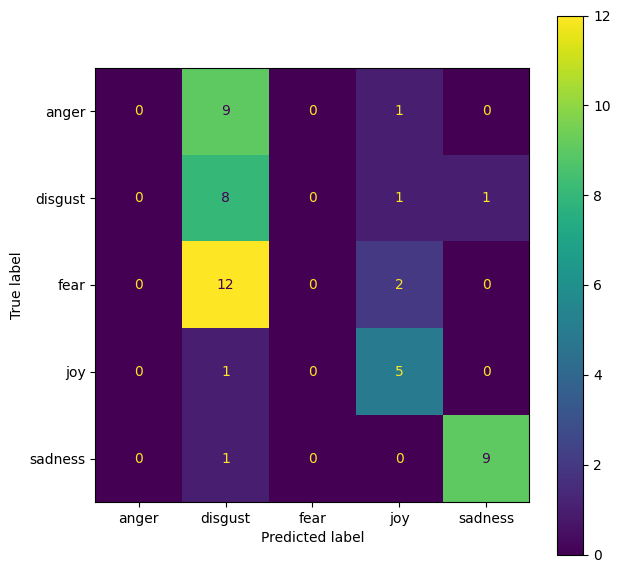

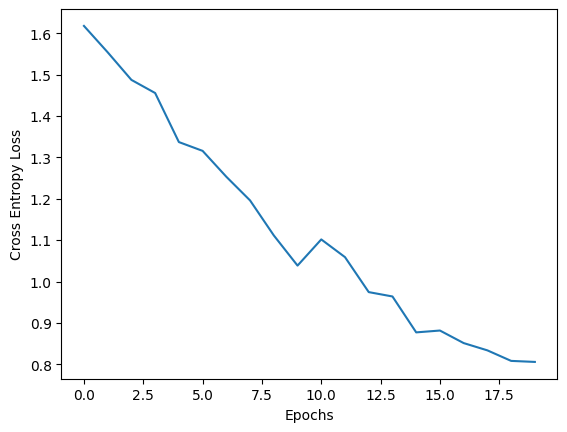

In [23]:
from sklearn import metrics

predicts = []
corrects = []

with torch.no_grad():
  model.train()
  train_loss = 0.00
  correct = 0.00
  total = 0.00
  for indices, label in test_loader:
    indices = indices.long().to(device)
    label = label.long().to(device)

    # getting the text for the index-th video
    text_batch = []
    for index in indices:
      text = get_text(index.cpu()).long()
      # if the text ends up being nothing
      if text_lengths[index] == 0:
        text[0] = 1
        # dimensionality voodoo
        text_lengths[index] = 1
      text_batch.append(text)
    text_batch = torch.stack(text_batch)
    text_batch = text_batch.squeeze(1)

    # getting the spectrograms
    spect_batch = []
    for index in indices:
      spect = get_spect(index.cpu())
      spect.requires_grad = True
      spect_batch.append(spect)
    spect_batch = torch.stack(spect_batch)
    spect_batch = spect_batch.squeeze(1)

    # getting all of the frames
    frame_batch = []
    for index in indices:
      frames = get_frame(index.cpu())
      frames = frames.squeeze(0)
      #print(frames.size())
      frame_batch.append(frames)
    frame_batch = torch.stack(frame_batch)
    frame_batch = torch.transpose(frame_batch, 1, 2)
    #print(frame_batch.size())

    # getting the text lengths
    textl = []
    for index in indices:
      textl.append(text_lengths[index])

    # output of the final NN on the super-tensor
    y_pred = model(spect_batch, text_batch, textl, frame_batch).to(device)

    # creating one-hot vector for the label for the index-th video
    labels = torch.full((b_size, 5,), 0.00).cuda()
    for j in range(b_size):
      labels[j][label[j]] = 1.00

    # computing the Cross Entropy Loss and backpropagating
    loss = loss_fn(y_pred, labels)

    # statistics
    train_loss += loss.item()/len(train_loader)
    prediction = y_pred.argmax(dim=1)
    label = label.squeeze(1)
    correct += (prediction.eq(label).sum()).item()
    total += label.size(0)

    # confusion matrix
    for i in range(b_size):
      predicts.append(prediction[i].item())
      corrects.append(label[i].item())

print(f"Validation Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {correct/total:.4f}")

mapping = ["anger", "disgust", "fear", "joy", "sadness"]

confucian = metrics.confusion_matrix(corrects, predicts)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confucian, display_labels = mapping)
fig, ax = plt.subplots(figsize=(7,7))
cm_display.plot(ax = ax)
plt.show()

plt.plot(tl)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()